In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from torch.cuda import amp

In [3]:
# Set CUDA environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"Current Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available!
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
# Define a custom ResNet model with added dropout and a fully connected layer
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
# Define dataset class
class LungImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_folder, classes, transform=None):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.classes = classes
        self.data = self._load_data()

    def _load_data(self):
        data = []
        label_mapping = {class_name: idx for idx, class_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_folder = os.path.join(self.dataset_folder, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    if os.path.isfile(img_path):
                        data.append((img_path, label_mapping[class_name]))

        print(f"Loaded {len(data)} images from {self.dataset_folder}")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [7]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_loss / total_val
    val_accuracy = correct_val / total_val

    # Convert collected values to numpy arrays
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    return val_loss, val_accuracy, all_labels, all_probs

In [8]:
import torch
from torch import amp

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    model.to(device)
    best_accuracy = 0.0
    use_amp = device.type == "cuda"

    # ✅ FIXED: Use `torch.amp.GradScaler('cuda')`
    scaler = torch.amp.GradScaler('cuda') if use_amp else None  

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # ✅ FIXED: Use `torch.amp.autocast('cuda', enabled=use_amp)`
            with torch.amp.autocast('cuda', enabled=use_amp):  
                outputs = model(images)
                loss = criterion(outputs, labels)

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train

        # Validate Model
        val_loss, val_accuracy, _, _ = validate(model, val_loader, criterion, device)

        # Adjust Learning Rate
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save best model based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "newmodel.pth")
            print("Saved best model with highest validation accuracy!")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
            print(f"Saved model at epoch {epoch+1}")


In [9]:
# Plotting functions for evaluation
def plot_roc_curve(labels, probs, num_classes):
    labels_bin = label_binarize(labels, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_pr_curve(labels, probs, num_classes):
    labels_bin = label_binarize(labels, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(labels_bin[:, i], probs[:, i])
        f1 = f1_score(labels_bin[:, i], (probs[:, i] > 0.5).astype(int))
        plt.plot(recall, precision, label=f'Class {i} (F1 = {f1:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_f1_curve(labels, probs, num_classes):
    labels_bin = label_binarize(labels, classes=np.arange(num_classes))

    f1_scores = []
    for i in range(num_classes):
        f1 = f1_score(labels_bin[:, i], (probs[:, i] > 0.5).astype(int))
        f1_scores.append(f1)

    plt.figure(figsize=(10, 8))
    plt.plot(np.arange(num_classes), f1_scores, marker='o', linestyle='--', color='b')
    plt.xticks(np.arange(num_classes), [f'Class {i}' for i in range(num_classes)], rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for each class')
    plt.show()

def evaluate_and_plot(model, val_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # Plotting the curves
    plot_roc_curve(all_labels, all_probs, num_classes)
    plot_pr_curve(all_labels, all_probs, num_classes)
    plot_f1_curve(all_labels, all_probs, num_classes)

Loaded 34535 images from C:\Users\Acer\Desktop\Model\Split\train
Loaded 7402 images from C:\Users\Acer\Desktop\Model\Split\val
Loaded 7408 images from C:\Users\Acer\Desktop\Model\Split\test
Epoch [1/100] Train Loss: 1.3357, Train Accuracy: 0.6192, Val Loss: 1.1076, Val Accuracy: 0.7197
Saved best model with highest validation accuracy!
Epoch [2/100] Train Loss: 1.0398, Train Accuracy: 0.7611, Val Loss: 1.0199, Val Accuracy: 0.7651
Saved best model with highest validation accuracy!
Epoch [3/100] Train Loss: 0.9174, Train Accuracy: 0.8184, Val Loss: 0.9127, Val Accuracy: 0.8149
Saved best model with highest validation accuracy!
Epoch [4/100] Train Loss: 0.8259, Train Accuracy: 0.8600, Val Loss: 0.8823, Val Accuracy: 0.8296
Saved best model with highest validation accuracy!
Epoch [5/100] Train Loss: 0.7636, Train Accuracy: 0.8896, Val Loss: 0.8550, Val Accuracy: 0.8434
Saved best model with highest validation accuracy!
Epoch [6/100] Train Loss: 0.7298, Train Accuracy: 0.9055, Val Loss: 0.

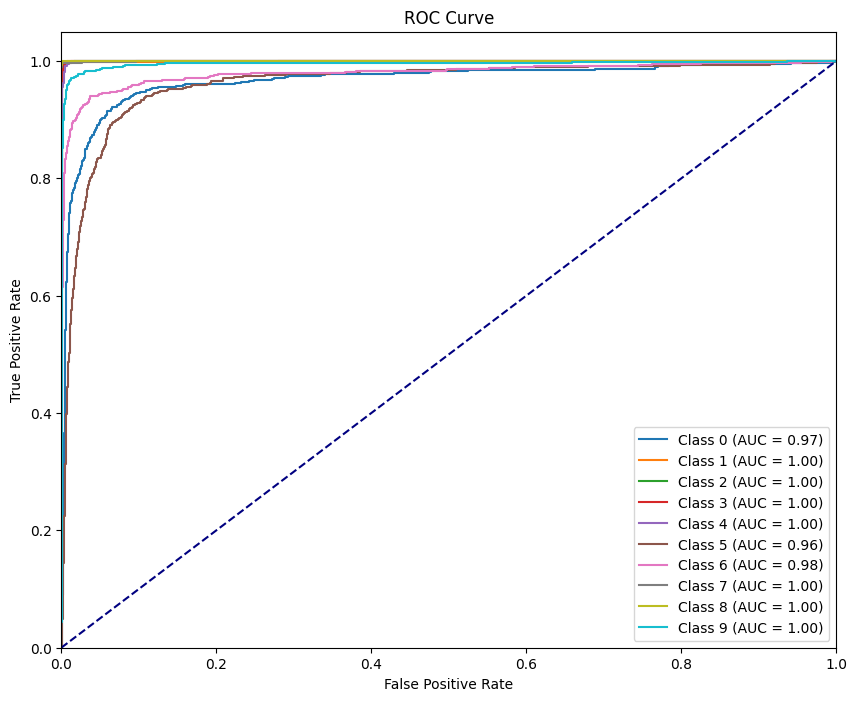

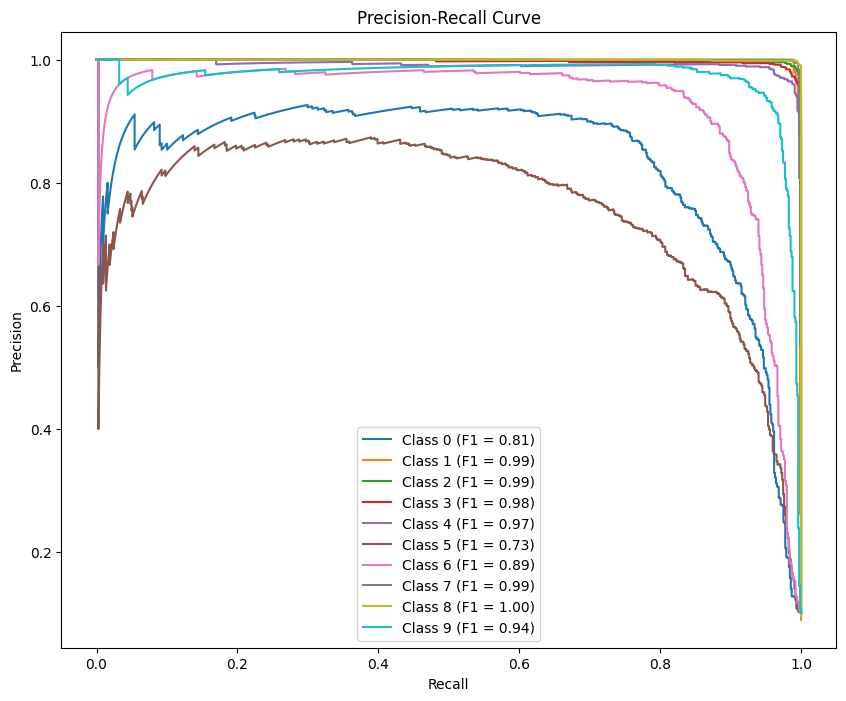

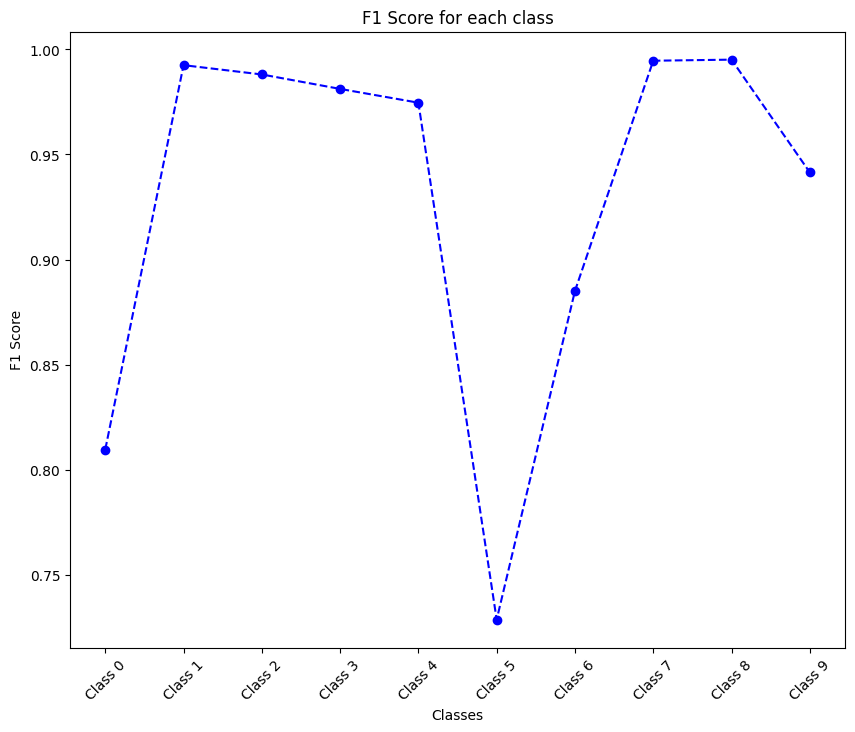

In [10]:
# Main function
def main():
    dataset_folder = "C:\\Users\\Acer\\Desktop\\Model\\Split"
    classes = ['Atelectasis', 'Covid19', 'Emphysema', 'Consolidation', 'Cardiomegaly', 'Infiltration', 'Nodule', 'Pneumonia', 'NORMAL', 'Pneumothorax']

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    train_dataset = LungImageDataset(dataset_folder=os.path.join(dataset_folder, "train"), classes=classes, transform=transform)
    val_dataset = LungImageDataset(dataset_folder=os.path.join(dataset_folder, "val"), classes=classes, transform=transform)
    test_dataset = LungImageDataset(dataset_folder=os.path.join(dataset_folder, "test"), classes=classes, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = CustomResNet(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # Train the model
    train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100)

    # After training is complete, call the function to plot the metrics
    evaluate_and_plot(model, val_loader, device, num_classes=len(classes))

if __name__ == "__main__":
    main()